<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [AE1] - Building and training an AE denoiser model
<!-- DESC --> Episode 1 : After construction, the model is trained with noisy data from the MNIST dataset.

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a denoizing **autoencoder** neurals network (AE)
 - Understanding a more **advanced programming model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST.  
The use of a GPU is often indispensable.

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Follow the learning process with Tensorboard

Thanks to **François Chollet** whose VAE example has greatly inspired this example.  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from modules.callbacks          import ImagesCallback
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import os,sys,json,time,datetime
from importlib import reload
from IPython.display import display,Image,Markdown,HTML
import h5py

from skimage import io
from skimage.util import random_noise

import modules.AE
from modules.AE           import AE
from modules.loader_MNIST import Loader_MNIST
from modules.callbacks    import ImagesCallback, BestModelCallback

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('AE1')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.7
Notebook id          : AE1
Run time             : Wednesday 27 January 2021, 19:22:49
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Prepare data
### 2.1 - Get MNIST dataset

In [2]:
x_data, y_data = Loader_MNIST.get()

Dataset loaded.
Normalized.
Expanded.
Concatenate.
x shape : (70000, 28, 28, 1)
y shape : (70000,)


### 2.2 - Add noise to dataset
We will add noise to our input dataset (x_data)  
Our goal is to predict noiselessly data (y_data)

In [3]:
def noise_it(x_data, about):
    for i,image in enumerate(x_data):
        pwk.update_progress(about,i+1,len(x_data))
        image=random_noise(image, mode='gaussian', mean=0, var=0.3)
        image=random_noise(image, mode='s&p',      amount=0.2, salt_vs_pepper=0.5)
        image=random_noise(image, mode='poisson') 
        image=random_noise(image, mode='speckle',  mean=0, var=0.1)
        x_data[i]=image
    return x_data


# ---- What we want to predict
#
y_data = np.copy(x_data)

# ---- Add noise to input data
#
x_data = noise_it(x_data, 'Add noise to x_train :')


Add noise to x_train : [########################################] 100.0% of 70000


### 2.3 - Have a look

Noisy dataset (x_data) :  (70000, 28, 28, 1)
Clean dataset (y_data) :  (70000, 28, 28, 1)


<br>**Noisy images (input data)**

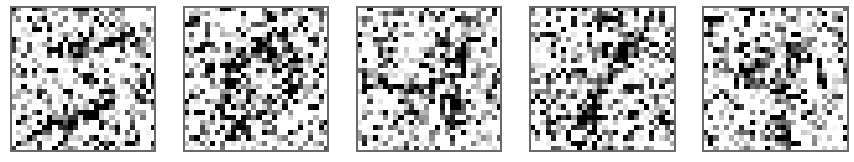

<br>**Original images we want to obtain (output data)**

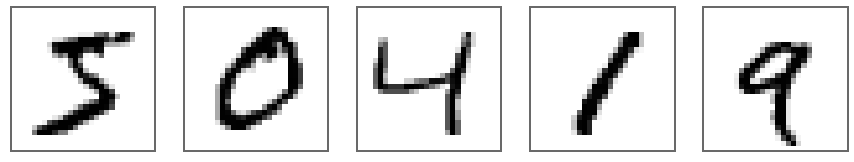

In [4]:
print('Noisy dataset (x_data) : ',x_data.shape)
print('Clean dataset (y_data) : ',y_data.shape)

pwk.subtitle('Noisy images (input data)')
pwk.plot_images(x_data[:5], None, indices='all', columns=5, x_size=3,y_size=3, interpolation=None, save_as='01-noisy')
pwk.subtitle('Original images we want to obtain (output data)')
pwk.plot_images(y_data[:5], None, indices='all', columns=5, x_size=3,y_size=3, interpolation=None, save_as='02-original')


### 2.4 - Shuffle and split dataset

In [5]:
p = np.random.permutation(len(x_data))
x_data, y_data = x_data[p], y_data[p]
x_train, y_train = x_data[:60000], y_data[:60000]
x_test,  y_test  = x_data[60000:], y_data[60000:]

print(f'x_train:{x_train.shape}  y_train:{y_train.shape}')
print(f'x_test :{x_test.shape}  y_test :{y_test.shape}')

x_train:(60000, 28, 28, 1)  y_train:(60000, 28, 28, 1)
x_test :(10000, 28, 28, 1)  y_test :(10000, 28, 28, 1)


### 2.5 - Save it

In [6]:
pwk.mkdir('./data')

with h5py.File('./data/mnist-noisy.h5', "w") as f:
    f.create_dataset("x_train", data=x_train)
    f.create_dataset("y_train", data=y_train)
    f.create_dataset("x_test",  data=x_test)
    f.create_dataset("y_test",  data=y_test)
    print('Saved.')

Saved.


## Step 3 - Build model

In [7]:
latent_dim = 10

#### Encoder

In [8]:
reload(modules.AE)
from modules.AE          import AE

inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x         = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)
z         = layers.Dense(latent_dim)(x)

encoder = keras.Model(inputs, z, name="encoder")
encoder.compile()
# encoder.summary()

#### Decoder

In [9]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x       = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.compile()
# decoder.summary()

#### AE


In [10]:
ae = AE(encoder, decoder)

ae.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy')

## Step 4 - Train
20' on a CPU  
1'12 on a GPU (V100, IDRIS)

In [11]:
# ---- Callback : Images
pwk.mkdir('./run/images')
filename = './run/images/image-{epoch:03d}-{i:02d}.jpg'
callback_images = ImagesCallback(filename, x=x_test[:5], encoder=encoder,decoder=decoder)

# ---- Callback : Best model
pwk.mkdir('./run/models')
filename = './run/models/best_model'
callback_bestmodel = BestModelCallback(filename)

# ---- Callback tensorboard
dirname = './run/logs'
callback_tensorboard = TensorBoard(log_dir=dirname, histogram_freq=1)

callbacks_list = [callback_images, callback_bestmodel, callback_tensorboard]

In [12]:
%%time

n          = 60000
batch_size = 128
epochs     = 30

history = ae.fit(x_train[:n],y_train[:n], epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/30


  1/469 [..............................] - ETA: 0s - loss: 0.6930

  5/469 [..............................] - ETA: 4s - loss: 0.6859

 17/469 [>.............................] - ETA: 2s - loss: 0.5524

 29/469 [>.............................] - ETA: 2s - loss: 0.4520

 41/469 [=>............................] - ETA: 2s - loss: 0.4002

 53/469 [==>...........................] - ETA: 2s - loss: 0.3702

 65/469 [===>..........................] - ETA: 1s - loss: 0.3514

 77/469 [===>..........................] - ETA: 1s - loss: 0.3382

 90/469 [====>.........................] - ETA: 1s - loss: 0.3278

103/469 [=====>........................] - ETA: 1s - loss: 0.3197

116/469 [======>.......................] - ETA: 1s - loss: 0.3135

129/469 [=======>......................] - ETA: 1s - loss: 0.3086

142/469 [========>.....................] - ETA: 1s - loss: 0.3047

155/469 [========>.....................] - ETA: 1s - loss: 0.3011

168/469 [=========>....................] - ETA: 1s - loss: 0.2983

181/469 [==========>...................] - ETA: 1s - loss: 0.2958

194/469 [===========>..................] - ETA: 1s - loss: 0.2936

207/469 [============>.................] - ETA: 1s - loss: 0.2917

220/469 [=============>................] - ETA: 1s - loss: 0.2899

233/469 [=============>................] - ETA: 1s - loss: 0.2881

246/469 [==============>...............] - ETA: 0s - loss: 0.2864

259/469 [===============>..............] - ETA: 0s - loss: 0.2846

272/469 [================>.............] - ETA: 0s - loss: 0.2829

285/469 [=================>............] - ETA: 0s - loss: 0.2812

298/469 [==================>...........] - ETA: 0s - loss: 0.2797

311/469 [==================>...........] - ETA: 0s - loss: 0.2780

324/469 [===================>..........] - ETA: 0s - loss: 0.2761

337/469 [====================>.........] - ETA: 0s - loss: 0.2743

350/469 [=====================>........] - ETA: 0s - loss: 0.2722

363/469 [======================>.......] - ETA: 0s - loss: 0.2702

376/469 [=======================>......] - ETA: 0s - loss: 0.2683

389/469 [=======================>......] - ETA: 0s - loss: 0.2663

402/469 [========================>.....] - ETA: 0s - loss: 0.2645

415/469 [=========================>....] - ETA: 0s - loss: 0.2628

428/469 [==========================>...] - ETA: 0s - loss: 0.2610

441/469 [===========================>..] - ETA: 0s - loss: 0.2594

454/469 [============================>.] - ETA: 0s - loss: 0.2578

467/469 [============================>.] - ETA: 0s - loss: 0.2562

469/469 [==============================] - ETA: 0s - loss: 0.2560

469/469 [==============================] - 3s 6ms/step - loss: 0.2560


Epoch 2/30
  1/469 [..............................] - ETA: 0s - loss: 0.1923

 14/469 [..............................] - ETA: 1s - loss: 0.1980

 27/469 [>.............................] - ETA: 1s - loss: 0.1967

 40/469 [=>............................] - ETA: 1s - loss: 0.1957

 53/469 [==>...........................] - ETA: 1s - loss: 0.1945

 66/469 [===>..........................] - ETA: 1s - loss: 0.1932

 79/469 [====>.........................] - ETA: 1s - loss: 0.1925

 92/469 [====>.........................] - ETA: 1s - loss: 0.1916

105/469 [=====>........................] - ETA: 1s - loss: 0.1910

118/469 [======>.......................] - ETA: 1s - loss: 0.1902

131/469 [=======>......................] - ETA: 1s - loss: 0.1897

144/469 [========>.....................] - ETA: 1s - loss: 0.1891

157/469 [=========>....................] - ETA: 1s - loss: 0.1883

170/469 [=========>....................] - ETA: 1s - loss: 0.1879

183/469 [==========>...................] - ETA: 1s - loss: 0.1874

196/469 [===========>..................] - ETA: 1s - loss: 0.1869

209/469 [============>.................] - ETA: 1s - loss: 0.1865

222/469 [=============>................] - ETA: 1s - loss: 0.1862

235/469 [==============>...............] - ETA: 0s - loss: 0.1857

248/469 [==============>...............] - ETA: 0s - loss: 0.1853

261/469 [===============>..............] - ETA: 0s - loss: 0.1848

274/469 [================>.............] - ETA: 0s - loss: 0.1844

287/469 [=================>............] - ETA: 0s - loss: 0.1839

300/469 [==================>...........] - ETA: 0s - loss: 0.1835

313/469 [===================>..........] - ETA: 0s - loss: 0.1833

326/469 [===================>..........] - ETA: 0s - loss: 0.1829

339/469 [====================>.........] - ETA: 0s - loss: 0.1826

352/469 [=====================>........] - ETA: 0s - loss: 0.1822

365/469 [======================>.......] - ETA: 0s - loss: 0.1819

378/469 [=======================>......] - ETA: 0s - loss: 0.1816

391/469 [========================>.....] - ETA: 0s - loss: 0.1812

404/469 [========================>.....] - ETA: 0s - loss: 0.1810

417/469 [=========================>....] - ETA: 0s - loss: 0.1807

430/469 [==========================>...] - ETA: 0s - loss: 0.1804

443/469 [===========================>..] - ETA: 0s - loss: 0.1802

456/469 [============================>.] - ETA: 0s - loss: 0.1799

469/469 [==============================] - ETA: 0s - loss: 0.1796

469/469 [==============================] - 2s 5ms/step - loss: 0.1796


Epoch 3/30
  1/469 [..............................] - ETA: 0s - loss: 0.1717

 14/469 [..............................] - ETA: 1s - loss: 0.1706

 27/469 [>.............................] - ETA: 1s - loss: 0.1697

 40/469 [=>............................] - ETA: 1s - loss: 0.1689

 53/469 [==>...........................] - ETA: 1s - loss: 0.1686

 66/469 [===>..........................] - ETA: 1s - loss: 0.1685

 79/469 [====>.........................] - ETA: 1s - loss: 0.1689

 92/469 [====>.........................] - ETA: 1s - loss: 0.1684

105/469 [=====>........................] - ETA: 1s - loss: 0.1684

118/469 [======>.......................] - ETA: 1s - loss: 0.1683

131/469 [=======>......................] - ETA: 1s - loss: 0.1682

144/469 [========>.....................] - ETA: 1s - loss: 0.1684

157/469 [=========>....................] - ETA: 1s - loss: 0.1684

170/469 [=========>....................] - ETA: 1s - loss: 0.1683

183/469 [==========>...................] - ETA: 1s - loss: 0.1682

196/469 [===========>..................] - ETA: 1s - loss: 0.1681

209/469 [============>.................] - ETA: 1s - loss: 0.1681

222/469 [=============>................] - ETA: 1s - loss: 0.1680

235/469 [==============>...............] - ETA: 0s - loss: 0.1678

248/469 [==============>...............] - ETA: 0s - loss: 0.1677

261/469 [===============>..............] - ETA: 0s - loss: 0.1676

274/469 [================>.............] - ETA: 0s - loss: 0.1675

287/469 [=================>............] - ETA: 0s - loss: 0.1674

300/469 [==================>...........] - ETA: 0s - loss: 0.1674

313/469 [===================>..........] - ETA: 0s - loss: 0.1672

326/469 [===================>..........] - ETA: 0s - loss: 0.1672

339/469 [====================>.........] - ETA: 0s - loss: 0.1670

352/469 [=====================>........] - ETA: 0s - loss: 0.1669

365/469 [======================>.......] - ETA: 0s - loss: 0.1668

378/469 [=======================>......] - ETA: 0s - loss: 0.1666

391/469 [========================>.....] - ETA: 0s - loss: 0.1665

404/469 [========================>.....] - ETA: 0s - loss: 0.1664

417/469 [=========================>....] - ETA: 0s - loss: 0.1663

430/469 [==========================>...] - ETA: 0s - loss: 0.1663

443/469 [===========================>..] - ETA: 0s - loss: 0.1662

456/469 [============================>.] - ETA: 0s - loss: 0.1661

469/469 [==============================] - ETA: 0s - loss: 0.1660

           (saved) 

469/469 [==============================] - 2s 4ms/step - loss: 0.1660


Epoch 4/30
  1/469 [..............................] - ETA: 0s - loss: 0.1627

 14/469 [..............................] - ETA: 1s - loss: 0.1594

 27/469 [>.............................] - ETA: 1s - loss: 0.1610

 40/469 [=>............................] - ETA: 1s - loss: 0.1609

 53/469 [==>...........................] - ETA: 1s - loss: 0.1609

 66/469 [===>..........................] - ETA: 1s - loss: 0.1605

 79/469 [====>.........................] - ETA: 1s - loss: 0.1602

 92/469 [====>.........................] - ETA: 1s - loss: 0.1604

105/469 [=====>........................] - ETA: 1s - loss: 0.1605

118/469 [======>.......................] - ETA: 1s - loss: 0.1605

131/469 [=======>......................] - ETA: 1s - loss: 0.1608

144/469 [========>.....................] - ETA: 1s - loss: 0.1607

157/469 [=========>....................] - ETA: 1s - loss: 0.1605

170/469 [=========>....................] - ETA: 1s - loss: 0.1604

183/469 [==========>...................] - ETA: 1s - loss: 0.1605

196/469 [===========>..................] - ETA: 1s - loss: 0.1605

209/469 [============>.................] - ETA: 1s - loss: 0.1605

222/469 [=============>................] - ETA: 1s - loss: 0.1605

235/469 [==============>...............] - ETA: 0s - loss: 0.1604

248/469 [==============>...............] - ETA: 0s - loss: 0.1604

261/469 [===============>..............] - ETA: 0s - loss: 0.1603

274/469 [================>.............] - ETA: 0s - loss: 0.1604

287/469 [=================>............] - ETA: 0s - loss: 0.1602

300/469 [==================>...........] - ETA: 0s - loss: 0.1602

313/469 [===================>..........] - ETA: 0s - loss: 0.1602

326/469 [===================>..........] - ETA: 0s - loss: 0.1601

339/469 [====================>.........] - ETA: 0s - loss: 0.1600

352/469 [=====================>........] - ETA: 0s - loss: 0.1599

365/469 [======================>.......] - ETA: 0s - loss: 0.1600

378/469 [=======================>......] - ETA: 0s - loss: 0.1599

391/469 [========================>.....] - ETA: 0s - loss: 0.1599

404/469 [========================>.....] - ETA: 0s - loss: 0.1598

417/469 [=========================>....] - ETA: 0s - loss: 0.1598

430/469 [==========================>...] - ETA: 0s - loss: 0.1597

443/469 [===========================>..] - ETA: 0s - loss: 0.1597

456/469 [============================>.] - ETA: 0s - loss: 0.1597

469/469 [==============================] - ETA: 0s - loss: 0.1596

           (saved) 

469/469 [==============================] - 2s 4ms/step - loss: 0.1596


Epoch 5/30
  1/469 [..............................] - ETA: 0s - loss: 0.1495

 14/469 [..............................] - ETA: 1s - loss: 0.1567

 27/469 [>.............................] - ETA: 1s - loss: 0.1569

 40/469 [=>............................] - ETA: 1s - loss: 0.1563

 53/469 [==>...........................] - ETA: 1s - loss: 0.1565

 66/469 [===>..........................] - ETA: 1s - loss: 0.1562

 79/469 [====>.........................] - ETA: 1s - loss: 0.1562

 92/469 [====>.........................] - ETA: 1s - loss: 0.1561

105/469 [=====>........................] - ETA: 1s - loss: 0.1563

118/469 [======>.......................] - ETA: 1s - loss: 0.1564

131/469 [=======>......................] - ETA: 1s - loss: 0.1564

144/469 [========>.....................] - ETA: 1s - loss: 0.1563

157/469 [=========>....................] - ETA: 1s - loss: 0.1562

170/469 [=========>....................] - ETA: 1s - loss: 0.1561

183/469 [==========>...................] - ETA: 1s - loss: 0.1560

196/469 [===========>..................] - ETA: 1s - loss: 0.1559

209/469 [============>.................] - ETA: 1s - loss: 0.1559

222/469 [=============>................] - ETA: 1s - loss: 0.1560

235/469 [==============>...............] - ETA: 0s - loss: 0.1560

248/469 [==============>...............] - ETA: 0s - loss: 0.1559

261/469 [===============>..............] - ETA: 0s - loss: 0.1559

274/469 [================>.............] - ETA: 0s - loss: 0.1559

287/469 [=================>............] - ETA: 0s - loss: 0.1559

300/469 [==================>...........] - ETA: 0s - loss: 0.1559

313/469 [===================>..........] - ETA: 0s - loss: 0.1558

326/469 [===================>..........] - ETA: 0s - loss: 0.1558

339/469 [====================>.........] - ETA: 0s - loss: 0.1558

352/469 [=====================>........] - ETA: 0s - loss: 0.1558

365/469 [======================>.......] - ETA: 0s - loss: 0.1558

378/469 [=======================>......] - ETA: 0s - loss: 0.1557

391/469 [========================>.....] - ETA: 0s - loss: 0.1557

404/469 [========================>.....] - ETA: 0s - loss: 0.1557

417/469 [=========================>....] - ETA: 0s - loss: 0.1556

430/469 [==========================>...] - ETA: 0s - loss: 0.1556

443/469 [===========================>..] - ETA: 0s - loss: 0.1556

456/469 [============================>.] - ETA: 0s - loss: 0.1556

469/469 [==============================] - ETA: 0s - loss: 0.1555

           (saved) 

469/469 [==============================] - 2s 4ms/step - loss: 0.1555


Epoch 6/30
  1/469 [..............................] - ETA: 0s - loss: 0.1478

 14/469 [..............................] - ETA: 1s - loss: 0.1517

 27/469 [>.............................] - ETA: 1s - loss: 0.1531

 40/469 [=>............................] - ETA: 1s - loss: 0.1526

 53/469 [==>...........................] - ETA: 1s - loss: 0.1529

 66/469 [===>..........................] - ETA: 1s - loss: 0.1531

 79/469 [====>.........................] - ETA: 1s - loss: 0.1530

 92/469 [====>.........................] - ETA: 1s - loss: 0.1529

105/469 [=====>........................] - ETA: 1s - loss: 0.1526

118/469 [======>.......................] - ETA: 1s - loss: 0.1524

131/469 [=======>......................] - ETA: 1s - loss: 0.1524

144/469 [========>.....................] - ETA: 1s - loss: 0.1525

157/469 [=========>....................] - ETA: 1s - loss: 0.1523

170/469 [=========>....................] - ETA: 1s - loss: 0.1523

183/469 [==========>...................] - ETA: 1s - loss: 0.1523

196/469 [===========>..................] - ETA: 1s - loss: 0.1522

209/469 [============>.................] - ETA: 1s - loss: 0.1524

222/469 [=============>................] - ETA: 1s - loss: 0.1524

235/469 [==============>...............] - ETA: 0s - loss: 0.1524

248/469 [==============>...............] - ETA: 0s - loss: 0.1525

261/469 [===============>..............] - ETA: 0s - loss: 0.1525

274/469 [================>.............] - ETA: 0s - loss: 0.1524

287/469 [=================>............] - ETA: 0s - loss: 0.1523

300/469 [==================>...........] - ETA: 0s - loss: 0.1523

313/469 [===================>..........] - ETA: 0s - loss: 0.1523

326/469 [===================>..........] - ETA: 0s - loss: 0.1523

339/469 [====================>.........] - ETA: 0s - loss: 0.1524

352/469 [=====================>........] - ETA: 0s - loss: 0.1524

365/469 [======================>.......] - ETA: 0s - loss: 0.1524

378/469 [=======================>......] - ETA: 0s - loss: 0.1524

391/469 [========================>.....] - ETA: 0s - loss: 0.1524

404/469 [========================>.....] - ETA: 0s - loss: 0.1524

417/469 [=========================>....] - ETA: 0s - loss: 0.1523

430/469 [==========================>...] - ETA: 0s - loss: 0.1523

443/469 [===========================>..] - ETA: 0s - loss: 0.1523

456/469 [============================>.] - ETA: 0s - loss: 0.1523

469/469 [==============================] - ETA: 0s - loss: 0.1524

469/469 [==============================] - 2s 4ms/step - loss: 0.1524


Epoch 7/30
  1/469 [..............................] - ETA: 0s - loss: 0.1486

 14/469 [..............................] - ETA: 1s - loss: 0.1501

 27/469 [>.............................] - ETA: 1s - loss: 0.1511

 40/469 [=>............................] - ETA: 1s - loss: 0.1511

 53/469 [==>...........................] - ETA: 1s - loss: 0.1506

 66/469 [===>..........................] - ETA: 1s - loss: 0.1504

 79/469 [====>.........................] - ETA: 1s - loss: 0.1500

 92/469 [====>.........................] - ETA: 1s - loss: 0.1499

105/469 [=====>........................] - ETA: 1s - loss: 0.1500

118/469 [======>.......................] - ETA: 1s - loss: 0.1502

131/469 [=======>......................] - ETA: 1s - loss: 0.1504

144/469 [========>.....................] - ETA: 1s - loss: 0.1503

157/469 [=========>....................] - ETA: 1s - loss: 0.1502

170/469 [=========>....................] - ETA: 1s - loss: 0.1503

183/469 [==========>...................] - ETA: 1s - loss: 0.1503

196/469 [===========>..................] - ETA: 1s - loss: 0.1504

209/469 [============>.................] - ETA: 1s - loss: 0.1504

222/469 [=============>................] - ETA: 1s - loss: 0.1505

235/469 [==============>...............] - ETA: 0s - loss: 0.1505

248/469 [==============>...............] - ETA: 0s - loss: 0.1505

261/469 [===============>..............] - ETA: 0s - loss: 0.1506

274/469 [================>.............] - ETA: 0s - loss: 0.1506

287/469 [=================>............] - ETA: 0s - loss: 0.1505

300/469 [==================>...........] - ETA: 0s - loss: 0.1504

313/469 [===================>..........] - ETA: 0s - loss: 0.1505

326/469 [===================>..........] - ETA: 0s - loss: 0.1504

339/469 [====================>.........] - ETA: 0s - loss: 0.1504

352/469 [=====================>........] - ETA: 0s - loss: 0.1503

365/469 [======================>.......] - ETA: 0s - loss: 0.1504

378/469 [=======================>......] - ETA: 0s - loss: 0.1505

391/469 [========================>.....] - ETA: 0s - loss: 0.1505

404/469 [========================>.....] - ETA: 0s - loss: 0.1505

417/469 [=========================>....] - ETA: 0s - loss: 0.1505

430/469 [==========================>...] - ETA: 0s - loss: 0.1505

443/469 [===========================>..] - ETA: 0s - loss: 0.1504

456/469 [============================>.] - ETA: 0s - loss: 0.1504

469/469 [==============================] - ETA: 0s - loss: 0.1504

469/469 [==============================] - 2s 4ms/step - loss: 0.1504


Epoch 8/30
  1/469 [..............................] - ETA: 0s - loss: 0.1555

 14/469 [..............................] - ETA: 1s - loss: 0.1479

 27/469 [>.............................] - ETA: 1s - loss: 0.1484

 40/469 [=>............................] - ETA: 1s - loss: 0.1483

 53/469 [==>...........................] - ETA: 1s - loss: 0.1477

 66/469 [===>..........................] - ETA: 1s - loss: 0.1481

 79/469 [====>.........................] - ETA: 1s - loss: 0.1480

 92/469 [====>.........................] - ETA: 1s - loss: 0.1482

105/469 [=====>........................] - ETA: 1s - loss: 0.1482

118/469 [======>.......................] - ETA: 1s - loss: 0.1482

131/469 [=======>......................] - ETA: 1s - loss: 0.1482

144/469 [========>.....................] - ETA: 1s - loss: 0.1484

157/469 [=========>....................] - ETA: 1s - loss: 0.1485

170/469 [=========>....................] - ETA: 1s - loss: 0.1484

183/469 [==========>...................] - ETA: 1s - loss: 0.1486

196/469 [===========>..................] - ETA: 1s - loss: 0.1487

209/469 [============>.................] - ETA: 1s - loss: 0.1486

222/469 [=============>................] - ETA: 1s - loss: 0.1487

235/469 [==============>...............] - ETA: 0s - loss: 0.1487

248/469 [==============>...............] - ETA: 0s - loss: 0.1487

261/469 [===============>..............] - ETA: 0s - loss: 0.1487

274/469 [================>.............] - ETA: 0s - loss: 0.1487

287/469 [=================>............] - ETA: 0s - loss: 0.1487

300/469 [==================>...........] - ETA: 0s - loss: 0.1488

313/469 [===================>..........] - ETA: 0s - loss: 0.1488

326/469 [===================>..........] - ETA: 0s - loss: 0.1488

339/469 [====================>.........] - ETA: 0s - loss: 0.1488

352/469 [=====================>........] - ETA: 0s - loss: 0.1488

365/469 [======================>.......] - ETA: 0s - loss: 0.1488

378/469 [=======================>......] - ETA: 0s - loss: 0.1489

391/469 [========================>.....] - ETA: 0s - loss: 0.1489

404/469 [========================>.....] - ETA: 0s - loss: 0.1488

417/469 [=========================>....] - ETA: 0s - loss: 0.1488

430/469 [==========================>...] - ETA: 0s - loss: 0.1489

443/469 [===========================>..] - ETA: 0s - loss: 0.1489

456/469 [============================>.] - ETA: 0s - loss: 0.1488

469/469 [==============================] - ETA: 0s - loss: 0.1489

           (saved) 

469/469 [==============================] - 2s 5ms/step - loss: 0.1489


Epoch 9/30
  1/469 [..............................] - ETA: 0s - loss: 0.1419

 14/469 [..............................] - ETA: 1s - loss: 0.1475

 27/469 [>.............................] - ETA: 1s - loss: 0.1473

 40/469 [=>............................] - ETA: 1s - loss: 0.1472

 53/469 [==>...........................] - ETA: 1s - loss: 0.1473

 66/469 [===>..........................] - ETA: 1s - loss: 0.1473

 79/469 [====>.........................] - ETA: 1s - loss: 0.1475

 92/469 [====>.........................] - ETA: 1s - loss: 0.1475

105/469 [=====>........................] - ETA: 1s - loss: 0.1475

118/469 [======>.......................] - ETA: 1s - loss: 0.1476

131/469 [=======>......................] - ETA: 1s - loss: 0.1474

144/469 [========>.....................] - ETA: 1s - loss: 0.1473

157/469 [=========>....................] - ETA: 1s - loss: 0.1473

170/469 [=========>....................] - ETA: 1s - loss: 0.1474

183/469 [==========>...................] - ETA: 1s - loss: 0.1475

196/469 [===========>..................] - ETA: 1s - loss: 0.1475

209/469 [============>.................] - ETA: 1s - loss: 0.1476

222/469 [=============>................] - ETA: 1s - loss: 0.1475

235/469 [==============>...............] - ETA: 0s - loss: 0.1474

248/469 [==============>...............] - ETA: 0s - loss: 0.1476

261/469 [===============>..............] - ETA: 0s - loss: 0.1476

274/469 [================>.............] - ETA: 0s - loss: 0.1477

287/469 [=================>............] - ETA: 0s - loss: 0.1477

300/469 [==================>...........] - ETA: 0s - loss: 0.1478

313/469 [===================>..........] - ETA: 0s - loss: 0.1478

326/469 [===================>..........] - ETA: 0s - loss: 0.1478

339/469 [====================>.........] - ETA: 0s - loss: 0.1478

352/469 [=====================>........] - ETA: 0s - loss: 0.1477

365/469 [======================>.......] - ETA: 0s - loss: 0.1477

378/469 [=======================>......] - ETA: 0s - loss: 0.1477

391/469 [========================>.....] - ETA: 0s - loss: 0.1477

404/469 [========================>.....] - ETA: 0s - loss: 0.1477

417/469 [=========================>....] - ETA: 0s - loss: 0.1478

430/469 [==========================>...] - ETA: 0s - loss: 0.1478

443/469 [===========================>..] - ETA: 0s - loss: 0.1478

456/469 [============================>.] - ETA: 0s - loss: 0.1478

469/469 [==============================] - ETA: 0s - loss: 0.1478

469/469 [==============================] - 2s 4ms/step - loss: 0.1478


Epoch 10/30
  1/469 [..............................] - ETA: 0s - loss: 0.1417

 14/469 [..............................] - ETA: 1s - loss: 0.1470

 27/469 [>.............................] - ETA: 1s - loss: 0.1474

 40/469 [=>............................] - ETA: 1s - loss: 0.1476

 53/469 [==>...........................] - ETA: 1s - loss: 0.1476

 66/469 [===>..........................] - ETA: 1s - loss: 0.1477

 79/469 [====>.........................] - ETA: 1s - loss: 0.1474

 92/469 [====>.........................] - ETA: 1s - loss: 0.1474

105/469 [=====>........................] - ETA: 1s - loss: 0.1473

118/469 [======>.......................] - ETA: 1s - loss: 0.1473

131/469 [=======>......................] - ETA: 1s - loss: 0.1473

144/469 [========>.....................] - ETA: 1s - loss: 0.1473

157/469 [=========>....................] - ETA: 1s - loss: 0.1475

170/469 [=========>....................] - ETA: 1s - loss: 0.1474

183/469 [==========>...................] - ETA: 1s - loss: 0.1475

196/469 [===========>..................] - ETA: 1s - loss: 0.1475

209/469 [============>.................] - ETA: 1s - loss: 0.1474

222/469 [=============>................] - ETA: 1s - loss: 0.1473

235/469 [==============>...............] - ETA: 0s - loss: 0.1471

248/469 [==============>...............] - ETA: 0s - loss: 0.1471

261/469 [===============>..............] - ETA: 0s - loss: 0.1471

274/469 [================>.............] - ETA: 0s - loss: 0.1470

287/469 [=================>............] - ETA: 0s - loss: 0.1471

300/469 [==================>...........] - ETA: 0s - loss: 0.1470

313/469 [===================>..........] - ETA: 0s - loss: 0.1469

326/469 [===================>..........] - ETA: 0s - loss: 0.1469

339/469 [====================>.........] - ETA: 0s - loss: 0.1470

352/469 [=====================>........] - ETA: 0s - loss: 0.1469

365/469 [======================>.......] - ETA: 0s - loss: 0.1469

378/469 [=======================>......] - ETA: 0s - loss: 0.1469

391/469 [========================>.....] - ETA: 0s - loss: 0.1469

404/469 [========================>.....] - ETA: 0s - loss: 0.1469

417/469 [=========================>....] - ETA: 0s - loss: 0.1469

430/469 [==========================>...] - ETA: 0s - loss: 0.1468

443/469 [===========================>..] - ETA: 0s - loss: 0.1468

456/469 [============================>.] - ETA: 0s - loss: 0.1468

469/469 [==============================] - ETA: 0s - loss: 0.1468

469/469 [==============================] - 2s 5ms/step - loss: 0.1468


Epoch 11/30
  1/469 [..............................] - ETA: 0s - loss: 0.1436

 14/469 [..............................] - ETA: 1s - loss: 0.1442

 27/469 [>.............................] - ETA: 1s - loss: 0.1449

 40/469 [=>............................] - ETA: 1s - loss: 0.1455

 53/469 [==>...........................] - ETA: 1s - loss: 0.1459

 66/469 [===>..........................] - ETA: 1s - loss: 0.1459

 79/469 [====>.........................] - ETA: 1s - loss: 0.1457

 92/469 [====>.........................] - ETA: 1s - loss: 0.1455

105/469 [=====>........................] - ETA: 1s - loss: 0.1457

118/469 [======>.......................] - ETA: 1s - loss: 0.1457

131/469 [=======>......................] - ETA: 1s - loss: 0.1457

144/469 [========>.....................] - ETA: 1s - loss: 0.1458

157/469 [=========>....................] - ETA: 1s - loss: 0.1459

170/469 [=========>....................] - ETA: 1s - loss: 0.1458

183/469 [==========>...................] - ETA: 1s - loss: 0.1459

196/469 [===========>..................] - ETA: 1s - loss: 0.1457

209/469 [============>.................] - ETA: 1s - loss: 0.1458

222/469 [=============>................] - ETA: 1s - loss: 0.1458

235/469 [==============>...............] - ETA: 0s - loss: 0.1459

248/469 [==============>...............] - ETA: 0s - loss: 0.1459

261/469 [===============>..............] - ETA: 0s - loss: 0.1459

274/469 [================>.............] - ETA: 0s - loss: 0.1460

287/469 [=================>............] - ETA: 0s - loss: 0.1460

300/469 [==================>...........] - ETA: 0s - loss: 0.1461

313/469 [===================>..........] - ETA: 0s - loss: 0.1462

326/469 [===================>..........] - ETA: 0s - loss: 0.1462

339/469 [====================>.........] - ETA: 0s - loss: 0.1461

352/469 [=====================>........] - ETA: 0s - loss: 0.1461

365/469 [======================>.......] - ETA: 0s - loss: 0.1461

378/469 [=======================>......] - ETA: 0s - loss: 0.1461

391/469 [========================>.....] - ETA: 0s - loss: 0.1460

404/469 [========================>.....] - ETA: 0s - loss: 0.1461

417/469 [=========================>....] - ETA: 0s - loss: 0.1461

430/469 [==========================>...] - ETA: 0s - loss: 0.1460

443/469 [===========================>..] - ETA: 0s - loss: 0.1460

456/469 [============================>.] - ETA: 0s - loss: 0.1460

469/469 [==============================] - ETA: 0s - loss: 0.1461

           (saved) 

469/469 [==============================] - 2s 4ms/step - loss: 0.1461


Epoch 12/30
  1/469 [..............................] - ETA: 0s - loss: 0.1489

 14/469 [..............................] - ETA: 1s - loss: 0.1447

 27/469 [>.............................] - ETA: 1s - loss: 0.1446

 40/469 [=>............................] - ETA: 1s - loss: 0.1452

 53/469 [==>...........................] - ETA: 1s - loss: 0.1454

 66/469 [===>..........................] - ETA: 1s - loss: 0.1454

 79/469 [====>.........................] - ETA: 1s - loss: 0.1452

 92/469 [====>.........................] - ETA: 1s - loss: 0.1451

105/469 [=====>........................] - ETA: 1s - loss: 0.1452

118/469 [======>.......................] - ETA: 1s - loss: 0.1454

131/469 [=======>......................] - ETA: 1s - loss: 0.1451

144/469 [========>.....................] - ETA: 1s - loss: 0.1453

157/469 [=========>....................] - ETA: 1s - loss: 0.1453

170/469 [=========>....................] - ETA: 1s - loss: 0.1454

183/469 [==========>...................] - ETA: 1s - loss: 0.1453

196/469 [===========>..................] - ETA: 1s - loss: 0.1453

209/469 [============>.................] - ETA: 1s - loss: 0.1454

222/469 [=============>................] - ETA: 0s - loss: 0.1454

235/469 [==============>...............] - ETA: 0s - loss: 0.1453

248/469 [==============>...............] - ETA: 0s - loss: 0.1453

261/469 [===============>..............] - ETA: 0s - loss: 0.1453

274/469 [================>.............] - ETA: 0s - loss: 0.1453

287/469 [=================>............] - ETA: 0s - loss: 0.1453

300/469 [==================>...........] - ETA: 0s - loss: 0.1453

313/469 [===================>..........] - ETA: 0s - loss: 0.1454

326/469 [===================>..........] - ETA: 0s - loss: 0.1454

339/469 [====================>.........] - ETA: 0s - loss: 0.1455

352/469 [=====================>........] - ETA: 0s - loss: 0.1454

365/469 [======================>.......] - ETA: 0s - loss: 0.1454

378/469 [=======================>......] - ETA: 0s - loss: 0.1454

391/469 [========================>.....] - ETA: 0s - loss: 0.1454

404/469 [========================>.....] - ETA: 0s - loss: 0.1454

417/469 [=========================>....] - ETA: 0s - loss: 0.1454

430/469 [==========================>...] - ETA: 0s - loss: 0.1455

443/469 [===========================>..] - ETA: 0s - loss: 0.1455

456/469 [============================>.] - ETA: 0s - loss: 0.1454

469/469 [==============================] - ETA: 0s - loss: 0.1454

           (saved) 

469/469 [==============================] - 2s 5ms/step - loss: 0.1454


Epoch 13/30
  1/469 [..............................] - ETA: 0s - loss: 0.1505

 14/469 [..............................] - ETA: 1s - loss: 0.1440

 27/469 [>.............................] - ETA: 1s - loss: 0.1446

 40/469 [=>............................] - ETA: 1s - loss: 0.1446

 53/469 [==>...........................] - ETA: 1s - loss: 0.1446

 66/469 [===>..........................] - ETA: 1s - loss: 0.1448

 79/469 [====>.........................] - ETA: 1s - loss: 0.1448

 92/469 [====>.........................] - ETA: 1s - loss: 0.1446

105/469 [=====>........................] - ETA: 1s - loss: 0.1445

118/469 [======>.......................] - ETA: 1s - loss: 0.1445

131/469 [=======>......................] - ETA: 1s - loss: 0.1445

144/469 [========>.....................] - ETA: 1s - loss: 0.1445

157/469 [=========>....................] - ETA: 1s - loss: 0.1445

170/469 [=========>....................] - ETA: 1s - loss: 0.1446

183/469 [==========>...................] - ETA: 1s - loss: 0.1446

196/469 [===========>..................] - ETA: 1s - loss: 0.1446

209/469 [============>.................] - ETA: 1s - loss: 0.1447

222/469 [=============>................] - ETA: 1s - loss: 0.1447

235/469 [==============>...............] - ETA: 0s - loss: 0.1447

248/469 [==============>...............] - ETA: 0s - loss: 0.1447

261/469 [===============>..............] - ETA: 0s - loss: 0.1448

274/469 [================>.............] - ETA: 0s - loss: 0.1448

287/469 [=================>............] - ETA: 0s - loss: 0.1448

300/469 [==================>...........] - ETA: 0s - loss: 0.1448

313/469 [===================>..........] - ETA: 0s - loss: 0.1448

326/469 [===================>..........] - ETA: 0s - loss: 0.1448

339/469 [====================>.........] - ETA: 0s - loss: 0.1449

352/469 [=====================>........] - ETA: 0s - loss: 0.1448

365/469 [======================>.......] - ETA: 0s - loss: 0.1449

378/469 [=======================>......] - ETA: 0s - loss: 0.1448

391/469 [========================>.....] - ETA: 0s - loss: 0.1448

404/469 [========================>.....] - ETA: 0s - loss: 0.1448

417/469 [=========================>....] - ETA: 0s - loss: 0.1448

430/469 [==========================>...] - ETA: 0s - loss: 0.1448

443/469 [===========================>..] - ETA: 0s - loss: 0.1448

456/469 [============================>.] - ETA: 0s - loss: 0.1448

469/469 [==============================] - ETA: 0s - loss: 0.1448

           (saved) 

469/469 [==============================] - 2s 4ms/step - loss: 0.1448


Epoch 14/30
  1/469 [..............................] - ETA: 0s - loss: 0.1378

 14/469 [..............................] - ETA: 1s - loss: 0.1448

 27/469 [>.............................] - ETA: 1s - loss: 0.1442

 40/469 [=>............................] - ETA: 1s - loss: 0.1443

 53/469 [==>...........................] - ETA: 1s - loss: 0.1437

 66/469 [===>..........................] - ETA: 1s - loss: 0.1437

 79/469 [====>.........................] - ETA: 1s - loss: 0.1435

 92/469 [====>.........................] - ETA: 1s - loss: 0.1434

105/469 [=====>........................] - ETA: 1s - loss: 0.1434

118/469 [======>.......................] - ETA: 1s - loss: 0.1438

131/469 [=======>......................] - ETA: 1s - loss: 0.1439

144/469 [========>.....................] - ETA: 1s - loss: 0.1439

157/469 [=========>....................] - ETA: 1s - loss: 0.1439

170/469 [=========>....................] - ETA: 1s - loss: 0.1439

183/469 [==========>...................] - ETA: 1s - loss: 0.1439

196/469 [===========>..................] - ETA: 1s - loss: 0.1440

209/469 [============>.................] - ETA: 1s - loss: 0.1440

222/469 [=============>................] - ETA: 1s - loss: 0.1440

234/469 [=============>................] - ETA: 0s - loss: 0.1440

247/469 [==============>...............] - ETA: 0s - loss: 0.1440

260/469 [===============>..............] - ETA: 0s - loss: 0.1440

273/469 [================>.............] - ETA: 0s - loss: 0.1440

286/469 [=================>............] - ETA: 0s - loss: 0.1441

299/469 [==================>...........] - ETA: 0s - loss: 0.1441

312/469 [==================>...........] - ETA: 0s - loss: 0.1441

325/469 [===================>..........] - ETA: 0s - loss: 0.1442

338/469 [====================>.........] - ETA: 0s - loss: 0.1443

350/469 [=====================>........] - ETA: 0s - loss: 0.1443

363/469 [======================>.......] - ETA: 0s - loss: 0.1443

376/469 [=======================>......] - ETA: 0s - loss: 0.1443

389/469 [=======================>......] - ETA: 0s - loss: 0.1442

402/469 [========================>.....] - ETA: 0s - loss: 0.1443

415/469 [=========================>....] - ETA: 0s - loss: 0.1443

428/469 [==========================>...] - ETA: 0s - loss: 0.1443

441/469 [===========================>..] - ETA: 0s - loss: 0.1443

454/469 [============================>.] - ETA: 0s - loss: 0.1443

467/469 [============================>.] - ETA: 0s - loss: 0.1443

           (saved) 

469/469 [==============================] - 2s 4ms/step - loss: 0.1443


Epoch 15/30
  1/469 [..............................] - ETA: 0s - loss: 0.1405

 14/469 [..............................] - ETA: 1s - loss: 0.1419

 27/469 [>.............................] - ETA: 1s - loss: 0.1425

 40/469 [=>............................] - ETA: 1s - loss: 0.1420

 52/469 [==>...........................] - ETA: 1s - loss: 0.1423

 65/469 [===>..........................] - ETA: 1s - loss: 0.1427

 78/469 [===>..........................] - ETA: 1s - loss: 0.1428

 91/469 [====>.........................] - ETA: 1s - loss: 0.1429

104/469 [=====>........................] - ETA: 1s - loss: 0.1429

117/469 [======>.......................] - ETA: 1s - loss: 0.1433

130/469 [=======>......................] - ETA: 1s - loss: 0.1434

143/469 [========>.....................] - ETA: 1s - loss: 0.1435

156/469 [========>.....................] - ETA: 1s - loss: 0.1436

169/469 [=========>....................] - ETA: 1s - loss: 0.1435

182/469 [==========>...................] - ETA: 1s - loss: 0.1436

195/469 [===========>..................] - ETA: 1s - loss: 0.1436

208/469 [============>.................] - ETA: 1s - loss: 0.1437

221/469 [=============>................] - ETA: 1s - loss: 0.1438

234/469 [=============>................] - ETA: 0s - loss: 0.1438

247/469 [==============>...............] - ETA: 0s - loss: 0.1438

260/469 [===============>..............] - ETA: 0s - loss: 0.1438

273/469 [================>.............] - ETA: 0s - loss: 0.1438

286/469 [=================>............] - ETA: 0s - loss: 0.1438

299/469 [==================>...........] - ETA: 0s - loss: 0.1438

312/469 [==================>...........] - ETA: 0s - loss: 0.1438

325/469 [===================>..........] - ETA: 0s - loss: 0.1438

338/469 [====================>.........] - ETA: 0s - loss: 0.1438

351/469 [=====================>........] - ETA: 0s - loss: 0.1437

364/469 [======================>.......] - ETA: 0s - loss: 0.1437

377/469 [=======================>......] - ETA: 0s - loss: 0.1437

390/469 [=======================>......] - ETA: 0s - loss: 0.1437

403/469 [========================>.....] - ETA: 0s - loss: 0.1437

416/469 [=========================>....] - ETA: 0s - loss: 0.1437

429/469 [==========================>...] - ETA: 0s - loss: 0.1438

442/469 [===========================>..] - ETA: 0s - loss: 0.1438

455/469 [============================>.] - ETA: 0s - loss: 0.1438

468/469 [============================>.] - ETA: 0s - loss: 0.1438

           (saved) 

469/469 [==============================] - 2s 4ms/step - loss: 0.1438


Epoch 16/30
  1/469 [..............................] - ETA: 0s - loss: 0.1436

 14/469 [..............................] - ETA: 1s - loss: 0.1432

 27/469 [>.............................] - ETA: 1s - loss: 0.1431

 40/469 [=>............................] - ETA: 1s - loss: 0.1427

 53/469 [==>...........................] - ETA: 1s - loss: 0.1427

 66/469 [===>..........................] - ETA: 1s - loss: 0.1427

 79/469 [====>.........................] - ETA: 1s - loss: 0.1429

 92/469 [====>.........................] - ETA: 1s - loss: 0.1430

105/469 [=====>........................] - ETA: 1s - loss: 0.1431

118/469 [======>.......................] - ETA: 1s - loss: 0.1432

131/469 [=======>......................] - ETA: 1s - loss: 0.1431

144/469 [========>.....................] - ETA: 1s - loss: 0.1431

157/469 [=========>....................] - ETA: 1s - loss: 0.1431

170/469 [=========>....................] - ETA: 1s - loss: 0.1431

183/469 [==========>...................] - ETA: 1s - loss: 0.1430

196/469 [===========>..................] - ETA: 1s - loss: 0.1431

209/469 [============>.................] - ETA: 1s - loss: 0.1432

222/469 [=============>................] - ETA: 1s - loss: 0.1431

235/469 [==============>...............] - ETA: 0s - loss: 0.1432

248/469 [==============>...............] - ETA: 0s - loss: 0.1432

261/469 [===============>..............] - ETA: 0s - loss: 0.1432

274/469 [================>.............] - ETA: 0s - loss: 0.1433

287/469 [=================>............] - ETA: 0s - loss: 0.1434

300/469 [==================>...........] - ETA: 0s - loss: 0.1434

313/469 [===================>..........] - ETA: 0s - loss: 0.1433

326/469 [===================>..........] - ETA: 0s - loss: 0.1433

339/469 [====================>.........] - ETA: 0s - loss: 0.1433

352/469 [=====================>........] - ETA: 0s - loss: 0.1433

365/469 [======================>.......] - ETA: 0s - loss: 0.1433

378/469 [=======================>......] - ETA: 0s - loss: 0.1433

391/469 [========================>.....] - ETA: 0s - loss: 0.1433

404/469 [========================>.....] - ETA: 0s - loss: 0.1433

417/469 [=========================>....] - ETA: 0s - loss: 0.1432

430/469 [==========================>...] - ETA: 0s - loss: 0.1432

443/469 [===========================>..] - ETA: 0s - loss: 0.1433

456/469 [============================>.] - ETA: 0s - loss: 0.1433

469/469 [==============================] - ETA: 0s - loss: 0.1433

469/469 [==============================] - 2s 4ms/step - loss: 0.1433


Epoch 17/30
  1/469 [..............................] - ETA: 0s - loss: 0.1478

 14/469 [..............................] - ETA: 1s - loss: 0.1418

 27/469 [>.............................] - ETA: 1s - loss: 0.1423

 40/469 [=>............................] - ETA: 1s - loss: 0.1419

 53/469 [==>...........................] - ETA: 1s - loss: 0.1419

 66/469 [===>..........................] - ETA: 1s - loss: 0.1422

 79/469 [====>.........................] - ETA: 1s - loss: 0.1422

 92/469 [====>.........................] - ETA: 1s - loss: 0.1424

105/469 [=====>........................] - ETA: 1s - loss: 0.1428

118/469 [======>.......................] - ETA: 1s - loss: 0.1425

131/469 [=======>......................] - ETA: 1s - loss: 0.1426

144/469 [========>.....................] - ETA: 1s - loss: 0.1424

157/469 [=========>....................] - ETA: 1s - loss: 0.1423

170/469 [=========>....................] - ETA: 1s - loss: 0.1423

183/469 [==========>...................] - ETA: 1s - loss: 0.1424

196/469 [===========>..................] - ETA: 1s - loss: 0.1424

209/469 [============>.................] - ETA: 1s - loss: 0.1424

222/469 [=============>................] - ETA: 1s - loss: 0.1426

235/469 [==============>...............] - ETA: 0s - loss: 0.1426

248/469 [==============>...............] - ETA: 0s - loss: 0.1427

261/469 [===============>..............] - ETA: 0s - loss: 0.1428

274/469 [================>.............] - ETA: 0s - loss: 0.1428

287/469 [=================>............] - ETA: 0s - loss: 0.1428

300/469 [==================>...........] - ETA: 0s - loss: 0.1428

313/469 [===================>..........] - ETA: 0s - loss: 0.1428

326/469 [===================>..........] - ETA: 0s - loss: 0.1428

339/469 [====================>.........] - ETA: 0s - loss: 0.1428

352/469 [=====================>........] - ETA: 0s - loss: 0.1428

365/469 [======================>.......] - ETA: 0s - loss: 0.1428

378/469 [=======================>......] - ETA: 0s - loss: 0.1429

391/469 [========================>.....] - ETA: 0s - loss: 0.1429

404/469 [========================>.....] - ETA: 0s - loss: 0.1429

417/469 [=========================>....] - ETA: 0s - loss: 0.1429

430/469 [==========================>...] - ETA: 0s - loss: 0.1429

443/469 [===========================>..] - ETA: 0s - loss: 0.1429

456/469 [============================>.] - ETA: 0s - loss: 0.1429

469/469 [==============================] - ETA: 0s - loss: 0.1429

469/469 [==============================] - 2s 4ms/step - loss: 0.1429


Epoch 18/30
  1/469 [..............................] - ETA: 0s - loss: 0.1476

 14/469 [..............................] - ETA: 1s - loss: 0.1419

 27/469 [>.............................] - ETA: 1s - loss: 0.1417

 40/469 [=>............................] - ETA: 1s - loss: 0.1425

 53/469 [==>...........................] - ETA: 1s - loss: 0.1427

 66/469 [===>..........................] - ETA: 1s - loss: 0.1424

 79/469 [====>.........................] - ETA: 1s - loss: 0.1423

 92/469 [====>.........................] - ETA: 1s - loss: 0.1423

105/469 [=====>........................] - ETA: 1s - loss: 0.1422

118/469 [======>.......................] - ETA: 1s - loss: 0.1421

131/469 [=======>......................] - ETA: 1s - loss: 0.1422

144/469 [========>.....................] - ETA: 1s - loss: 0.1422

157/469 [=========>....................] - ETA: 1s - loss: 0.1421

170/469 [=========>....................] - ETA: 1s - loss: 0.1422

183/469 [==========>...................] - ETA: 1s - loss: 0.1423

196/469 [===========>..................] - ETA: 1s - loss: 0.1423

209/469 [============>.................] - ETA: 1s - loss: 0.1422

222/469 [=============>................] - ETA: 0s - loss: 0.1423

235/469 [==============>...............] - ETA: 0s - loss: 0.1423

248/469 [==============>...............] - ETA: 0s - loss: 0.1423

261/469 [===============>..............] - ETA: 0s - loss: 0.1424

274/469 [================>.............] - ETA: 0s - loss: 0.1424

287/469 [=================>............] - ETA: 0s - loss: 0.1424

300/469 [==================>...........] - ETA: 0s - loss: 0.1424

313/469 [===================>..........] - ETA: 0s - loss: 0.1425

326/469 [===================>..........] - ETA: 0s - loss: 0.1425

339/469 [====================>.........] - ETA: 0s - loss: 0.1424

352/469 [=====================>........] - ETA: 0s - loss: 0.1425

365/469 [======================>.......] - ETA: 0s - loss: 0.1425

378/469 [=======================>......] - ETA: 0s - loss: 0.1425

391/469 [========================>.....] - ETA: 0s - loss: 0.1425

404/469 [========================>.....] - ETA: 0s - loss: 0.1425

417/469 [=========================>....] - ETA: 0s - loss: 0.1425

430/469 [==========================>...] - ETA: 0s - loss: 0.1426

443/469 [===========================>..] - ETA: 0s - loss: 0.1426

456/469 [============================>.] - ETA: 0s - loss: 0.1425

469/469 [==============================] - ETA: 0s - loss: 0.1425

469/469 [==============================] - 2s 4ms/step - loss: 0.1425


Epoch 19/30
  1/469 [..............................] - ETA: 0s - loss: 0.1410

 14/469 [..............................] - ETA: 1s - loss: 0.1413

 27/469 [>.............................] - ETA: 1s - loss: 0.1415

 40/469 [=>............................] - ETA: 1s - loss: 0.1408

 53/469 [==>...........................] - ETA: 1s - loss: 0.1415

 66/469 [===>..........................] - ETA: 1s - loss: 0.1417

 79/469 [====>.........................] - ETA: 1s - loss: 0.1416

 92/469 [====>.........................] - ETA: 1s - loss: 0.1418

105/469 [=====>........................] - ETA: 1s - loss: 0.1417

118/469 [======>.......................] - ETA: 1s - loss: 0.1418

131/469 [=======>......................] - ETA: 1s - loss: 0.1417

144/469 [========>.....................] - ETA: 1s - loss: 0.1417

157/469 [=========>....................] - ETA: 1s - loss: 0.1419

170/469 [=========>....................] - ETA: 1s - loss: 0.1419

183/469 [==========>...................] - ETA: 1s - loss: 0.1418

196/469 [===========>..................] - ETA: 1s - loss: 0.1418

209/469 [============>.................] - ETA: 1s - loss: 0.1418

222/469 [=============>................] - ETA: 0s - loss: 0.1418

235/469 [==============>...............] - ETA: 0s - loss: 0.1418

248/469 [==============>...............] - ETA: 0s - loss: 0.1418

261/469 [===============>..............] - ETA: 0s - loss: 0.1418

274/469 [================>.............] - ETA: 0s - loss: 0.1418

287/469 [=================>............] - ETA: 0s - loss: 0.1420

300/469 [==================>...........] - ETA: 0s - loss: 0.1419

313/469 [===================>..........] - ETA: 0s - loss: 0.1420

326/469 [===================>..........] - ETA: 0s - loss: 0.1420

339/469 [====================>.........] - ETA: 0s - loss: 0.1419

352/469 [=====================>........] - ETA: 0s - loss: 0.1420

365/469 [======================>.......] - ETA: 0s - loss: 0.1420

378/469 [=======================>......] - ETA: 0s - loss: 0.1420

391/469 [========================>.....] - ETA: 0s - loss: 0.1420

404/469 [========================>.....] - ETA: 0s - loss: 0.1420

417/469 [=========================>....] - ETA: 0s - loss: 0.1420

430/469 [==========================>...] - ETA: 0s - loss: 0.1420

443/469 [===========================>..] - ETA: 0s - loss: 0.1421

456/469 [============================>.] - ETA: 0s - loss: 0.1421

469/469 [==============================] - ETA: 0s - loss: 0.1422

469/469 [==============================] - 2s 4ms/step - loss: 0.1422


Epoch 20/30
  1/469 [..............................] - ETA: 0s - loss: 0.1424

 14/469 [..............................] - ETA: 1s - loss: 0.1414

 27/469 [>.............................] - ETA: 1s - loss: 0.1415

 40/469 [=>............................] - ETA: 1s - loss: 0.1407

 53/469 [==>...........................] - ETA: 1s - loss: 0.1406

 66/469 [===>..........................] - ETA: 1s - loss: 0.1407

 79/469 [====>.........................] - ETA: 1s - loss: 0.1407

 92/469 [====>.........................] - ETA: 1s - loss: 0.1408

105/469 [=====>........................] - ETA: 1s - loss: 0.1410

118/469 [======>.......................] - ETA: 1s - loss: 0.1411

131/469 [=======>......................] - ETA: 1s - loss: 0.1411

144/469 [========>.....................] - ETA: 1s - loss: 0.1411

157/469 [=========>....................] - ETA: 1s - loss: 0.1411

170/469 [=========>....................] - ETA: 1s - loss: 0.1410

183/469 [==========>...................] - ETA: 1s - loss: 0.1410

196/469 [===========>..................] - ETA: 1s - loss: 0.1410

209/469 [============>.................] - ETA: 1s - loss: 0.1410

222/469 [=============>................] - ETA: 1s - loss: 0.1411

235/469 [==============>...............] - ETA: 0s - loss: 0.1411

248/469 [==============>...............] - ETA: 0s - loss: 0.1412

261/469 [===============>..............] - ETA: 0s - loss: 0.1413

274/469 [================>.............] - ETA: 0s - loss: 0.1413

287/469 [=================>............] - ETA: 0s - loss: 0.1413

300/469 [==================>...........] - ETA: 0s - loss: 0.1413

313/469 [===================>..........] - ETA: 0s - loss: 0.1414

326/469 [===================>..........] - ETA: 0s - loss: 0.1414

339/469 [====================>.........] - ETA: 0s - loss: 0.1414

352/469 [=====================>........] - ETA: 0s - loss: 0.1414

365/469 [======================>.......] - ETA: 0s - loss: 0.1415

378/469 [=======================>......] - ETA: 0s - loss: 0.1416

391/469 [========================>.....] - ETA: 0s - loss: 0.1416

404/469 [========================>.....] - ETA: 0s - loss: 0.1417

417/469 [=========================>....] - ETA: 0s - loss: 0.1417

430/469 [==========================>...] - ETA: 0s - loss: 0.1417

443/469 [===========================>..] - ETA: 0s - loss: 0.1417

456/469 [============================>.] - ETA: 0s - loss: 0.1417

469/469 [==============================] - ETA: 0s - loss: 0.1418

469/469 [==============================] - 2s 4ms/step - loss: 0.1418


Epoch 21/30
  1/469 [..............................] - ETA: 0s - loss: 0.1347

 14/469 [..............................] - ETA: 1s - loss: 0.1398

 27/469 [>.............................] - ETA: 1s - loss: 0.1403

 40/469 [=>............................] - ETA: 1s - loss: 0.1405

 53/469 [==>...........................] - ETA: 1s - loss: 0.1410

 66/469 [===>..........................] - ETA: 1s - loss: 0.1412

 79/469 [====>.........................] - ETA: 1s - loss: 0.1412

 92/469 [====>.........................] - ETA: 1s - loss: 0.1412

105/469 [=====>........................] - ETA: 1s - loss: 0.1413

118/469 [======>.......................] - ETA: 1s - loss: 0.1413

131/469 [=======>......................] - ETA: 1s - loss: 0.1411

144/469 [========>.....................] - ETA: 1s - loss: 0.1411

157/469 [=========>....................] - ETA: 1s - loss: 0.1411

170/469 [=========>....................] - ETA: 1s - loss: 0.1409

183/469 [==========>...................] - ETA: 1s - loss: 0.1410

196/469 [===========>..................] - ETA: 1s - loss: 0.1409

209/469 [============>.................] - ETA: 1s - loss: 0.1409

222/469 [=============>................] - ETA: 0s - loss: 0.1409

235/469 [==============>...............] - ETA: 0s - loss: 0.1410

248/469 [==============>...............] - ETA: 0s - loss: 0.1412

261/469 [===============>..............] - ETA: 0s - loss: 0.1413

274/469 [================>.............] - ETA: 0s - loss: 0.1413

287/469 [=================>............] - ETA: 0s - loss: 0.1413

300/469 [==================>...........] - ETA: 0s - loss: 0.1414

313/469 [===================>..........] - ETA: 0s - loss: 0.1413

326/469 [===================>..........] - ETA: 0s - loss: 0.1414

339/469 [====================>.........] - ETA: 0s - loss: 0.1414

352/469 [=====================>........] - ETA: 0s - loss: 0.1414

365/469 [======================>.......] - ETA: 0s - loss: 0.1414

378/469 [=======================>......] - ETA: 0s - loss: 0.1414

391/469 [========================>.....] - ETA: 0s - loss: 0.1414

404/469 [========================>.....] - ETA: 0s - loss: 0.1415

417/469 [=========================>....] - ETA: 0s - loss: 0.1415

430/469 [==========================>...] - ETA: 0s - loss: 0.1415

443/469 [===========================>..] - ETA: 0s - loss: 0.1415

456/469 [============================>.] - ETA: 0s - loss: 0.1415

469/469 [==============================] - ETA: 0s - loss: 0.1415

469/469 [==============================] - 2s 4ms/step - loss: 0.1415


Epoch 22/30
  1/469 [..............................] - ETA: 0s - loss: 0.1362

 14/469 [..............................] - ETA: 1s - loss: 0.1404

 27/469 [>.............................] - ETA: 1s - loss: 0.1393

 40/469 [=>............................] - ETA: 1s - loss: 0.1398

 53/469 [==>...........................] - ETA: 1s - loss: 0.1397

 66/469 [===>..........................] - ETA: 1s - loss: 0.1399

 79/469 [====>.........................] - ETA: 1s - loss: 0.1401

 92/469 [====>.........................] - ETA: 1s - loss: 0.1402

105/469 [=====>........................] - ETA: 1s - loss: 0.1404

118/469 [======>.......................] - ETA: 1s - loss: 0.1404

131/469 [=======>......................] - ETA: 1s - loss: 0.1405

144/469 [========>.....................] - ETA: 1s - loss: 0.1406

157/469 [=========>....................] - ETA: 1s - loss: 0.1406

170/469 [=========>....................] - ETA: 1s - loss: 0.1406

183/469 [==========>...................] - ETA: 1s - loss: 0.1405

196/469 [===========>..................] - ETA: 1s - loss: 0.1406

209/469 [============>.................] - ETA: 1s - loss: 0.1408

222/469 [=============>................] - ETA: 0s - loss: 0.1409

235/469 [==============>...............] - ETA: 0s - loss: 0.1410

248/469 [==============>...............] - ETA: 0s - loss: 0.1411

261/469 [===============>..............] - ETA: 0s - loss: 0.1410

274/469 [================>.............] - ETA: 0s - loss: 0.1410

287/469 [=================>............] - ETA: 0s - loss: 0.1410

300/469 [==================>...........] - ETA: 0s - loss: 0.1410

313/469 [===================>..........] - ETA: 0s - loss: 0.1410

326/469 [===================>..........] - ETA: 0s - loss: 0.1410

339/469 [====================>.........] - ETA: 0s - loss: 0.1410

352/469 [=====================>........] - ETA: 0s - loss: 0.1410

365/469 [======================>.......] - ETA: 0s - loss: 0.1411

378/469 [=======================>......] - ETA: 0s - loss: 0.1411

391/469 [========================>.....] - ETA: 0s - loss: 0.1411

404/469 [========================>.....] - ETA: 0s - loss: 0.1411

417/469 [=========================>....] - ETA: 0s - loss: 0.1412

430/469 [==========================>...] - ETA: 0s - loss: 0.1412

443/469 [===========================>..] - ETA: 0s - loss: 0.1412

456/469 [============================>.] - ETA: 0s - loss: 0.1412

469/469 [==============================] - ETA: 0s - loss: 0.1413

469/469 [==============================] - 2s 4ms/step - loss: 0.1413


Epoch 23/30
  1/469 [..............................] - ETA: 0s - loss: 0.1437

 14/469 [..............................] - ETA: 1s - loss: 0.1421

 27/469 [>.............................] - ETA: 1s - loss: 0.1408

 40/469 [=>............................] - ETA: 1s - loss: 0.1404

 53/469 [==>...........................] - ETA: 1s - loss: 0.1404

 66/469 [===>..........................] - ETA: 1s - loss: 0.1401

 79/469 [====>.........................] - ETA: 1s - loss: 0.1404

 92/469 [====>.........................] - ETA: 1s - loss: 0.1406

105/469 [=====>........................] - ETA: 1s - loss: 0.1405

118/469 [======>.......................] - ETA: 1s - loss: 0.1406

131/469 [=======>......................] - ETA: 1s - loss: 0.1406

144/469 [========>.....................] - ETA: 1s - loss: 0.1407

157/469 [=========>....................] - ETA: 1s - loss: 0.1407

170/469 [=========>....................] - ETA: 1s - loss: 0.1408

183/469 [==========>...................] - ETA: 1s - loss: 0.1407

196/469 [===========>..................] - ETA: 1s - loss: 0.1407

209/469 [============>.................] - ETA: 1s - loss: 0.1407

222/469 [=============>................] - ETA: 0s - loss: 0.1408

235/469 [==============>...............] - ETA: 0s - loss: 0.1408

248/469 [==============>...............] - ETA: 0s - loss: 0.1409

261/469 [===============>..............] - ETA: 0s - loss: 0.1408

274/469 [================>.............] - ETA: 0s - loss: 0.1408

287/469 [=================>............] - ETA: 0s - loss: 0.1408

300/469 [==================>...........] - ETA: 0s - loss: 0.1408

313/469 [===================>..........] - ETA: 0s - loss: 0.1408

326/469 [===================>..........] - ETA: 0s - loss: 0.1409

339/469 [====================>.........] - ETA: 0s - loss: 0.1409

352/469 [=====================>........] - ETA: 0s - loss: 0.1409

365/469 [======================>.......] - ETA: 0s - loss: 0.1409

378/469 [=======================>......] - ETA: 0s - loss: 0.1410

391/469 [========================>.....] - ETA: 0s - loss: 0.1410

404/469 [========================>.....] - ETA: 0s - loss: 0.1410

417/469 [=========================>....] - ETA: 0s - loss: 0.1410

430/469 [==========================>...] - ETA: 0s - loss: 0.1410

443/469 [===========================>..] - ETA: 0s - loss: 0.1410

456/469 [============================>.] - ETA: 0s - loss: 0.1411

469/469 [==============================] - ETA: 0s - loss: 0.1411

469/469 [==============================] - 2s 4ms/step - loss: 0.1411


Epoch 24/30
  1/469 [..............................] - ETA: 0s - loss: 0.1397



 14/469 [..............................] - ETA: 1s - loss: 0.1393

 27/469 [>.............................] - ETA: 1s - loss: 0.1389

 40/469 [=>............................] - ETA: 1s - loss: 0.1391

 53/469 [==>...........................] - ETA: 1s - loss: 0.1392

 66/469 [===>..........................] - ETA: 1s - loss: 0.1392

 79/469 [====>.........................] - ETA: 1s - loss: 0.1393

 91/469 [====>.........................] - ETA: 1s - loss: 0.1393

104/469 [=====>........................] - ETA: 1s - loss: 0.1396

117/469 [======>.......................] - ETA: 1s - loss: 0.1396

130/469 [=======>......................] - ETA: 1s - loss: 0.1398

143/469 [========>.....................] - ETA: 1s - loss: 0.1398

155/469 [========>.....................] - ETA: 1s - loss: 0.1399

168/469 [=========>....................] - ETA: 1s - loss: 0.1399

181/469 [==========>...................] - ETA: 1s - loss: 0.1400

194/469 [===========>..................] - ETA: 1s - loss: 0.1402

207/469 [============>.................] - ETA: 1s - loss: 0.1402

220/469 [=============>................] - ETA: 1s - loss: 0.1402

233/469 [=============>................] - ETA: 0s - loss: 0.1403

246/469 [==============>...............] - ETA: 0s - loss: 0.1403

259/469 [===============>..............] - ETA: 0s - loss: 0.1403

272/469 [================>.............] - ETA: 0s - loss: 0.1404

285/469 [=================>............] - ETA: 0s - loss: 0.1403

298/469 [==================>...........] - ETA: 0s - loss: 0.1403

311/469 [==================>...........] - ETA: 0s - loss: 0.1403

324/469 [===================>..........] - ETA: 0s - loss: 0.1404

337/469 [====================>.........] - ETA: 0s - loss: 0.1404

349/469 [=====================>........] - ETA: 0s - loss: 0.1405

362/469 [======================>.......] - ETA: 0s - loss: 0.1405

375/469 [======================>.......] - ETA: 0s - loss: 0.1406

388/469 [=======================>......] - ETA: 0s - loss: 0.1407

401/469 [========================>.....] - ETA: 0s - loss: 0.1407

414/469 [=========================>....] - ETA: 0s - loss: 0.1407

427/469 [==========================>...] - ETA: 0s - loss: 0.1407

440/469 [===========================>..] - ETA: 0s - loss: 0.1407

453/469 [===========================>..] - ETA: 0s - loss: 0.1407

466/469 [============================>.] - ETA: 0s - loss: 0.1407

469/469 [==============================] - 2s 4ms/step - loss: 0.1407


Epoch 25/30
  1/469 [..............................] - ETA: 0s - loss: 0.1376

 14/469 [..............................] - ETA: 1s - loss: 0.1396

 27/469 [>.............................] - ETA: 1s - loss: 0.1406

 40/469 [=>............................] - ETA: 1s - loss: 0.1405

 53/469 [==>...........................] - ETA: 1s - loss: 0.1403

 66/469 [===>..........................] - ETA: 1s - loss: 0.1401

 79/469 [====>.........................] - ETA: 1s - loss: 0.1400

 92/469 [====>.........................] - ETA: 1s - loss: 0.1398

105/469 [=====>........................] - ETA: 1s - loss: 0.1401

118/469 [======>.......................] - ETA: 1s - loss: 0.1403

131/469 [=======>......................] - ETA: 1s - loss: 0.1402

144/469 [========>.....................] - ETA: 1s - loss: 0.1403

157/469 [=========>....................] - ETA: 1s - loss: 0.1403

170/469 [=========>....................] - ETA: 1s - loss: 0.1405

183/469 [==========>...................] - ETA: 1s - loss: 0.1404

196/469 [===========>..................] - ETA: 1s - loss: 0.1404

209/469 [============>.................] - ETA: 1s - loss: 0.1404

222/469 [=============>................] - ETA: 1s - loss: 0.1404

235/469 [==============>...............] - ETA: 0s - loss: 0.1404

248/469 [==============>...............] - ETA: 0s - loss: 0.1404

261/469 [===============>..............] - ETA: 0s - loss: 0.1403

274/469 [================>.............] - ETA: 0s - loss: 0.1404

287/469 [=================>............] - ETA: 0s - loss: 0.1404

300/469 [==================>...........] - ETA: 0s - loss: 0.1404

313/469 [===================>..........] - ETA: 0s - loss: 0.1404

326/469 [===================>..........] - ETA: 0s - loss: 0.1404

339/469 [====================>.........] - ETA: 0s - loss: 0.1405

352/469 [=====================>........] - ETA: 0s - loss: 0.1404

365/469 [======================>.......] - ETA: 0s - loss: 0.1405

378/469 [=======================>......] - ETA: 0s - loss: 0.1405

391/469 [========================>.....] - ETA: 0s - loss: 0.1405

404/469 [========================>.....] - ETA: 0s - loss: 0.1405

417/469 [=========================>....] - ETA: 0s - loss: 0.1405

430/469 [==========================>...] - ETA: 0s - loss: 0.1404

443/469 [===========================>..] - ETA: 0s - loss: 0.1405

456/469 [============================>.] - ETA: 0s - loss: 0.1405

469/469 [==============================] - ETA: 0s - loss: 0.1405

469/469 [==============================] - 2s 5ms/step - loss: 0.1405


Epoch 26/30


  1/469 [..............................] - ETA: 0s - loss: 0.1377

 14/469 [..............................] - ETA: 1s - loss: 0.1393

 27/469 [>.............................] - ETA: 1s - loss: 0.1394

 40/469 [=>............................] - ETA: 1s - loss: 0.1398

 53/469 [==>...........................] - ETA: 1s - loss: 0.1399

 66/469 [===>..........................] - ETA: 1s - loss: 0.1396

 79/469 [====>.........................] - ETA: 1s - loss: 0.1397

 92/469 [====>.........................] - ETA: 1s - loss: 0.1398

105/469 [=====>........................] - ETA: 1s - loss: 0.1400

118/469 [======>.......................] - ETA: 1s - loss: 0.1399

131/469 [=======>......................] - ETA: 1s - loss: 0.1400

144/469 [========>.....................] - ETA: 1s - loss: 0.1400

157/469 [=========>....................] - ETA: 1s - loss: 0.1401

170/469 [=========>....................] - ETA: 1s - loss: 0.1399

183/469 [==========>...................] - ETA: 1s - loss: 0.1400

196/469 [===========>..................] - ETA: 1s - loss: 0.1400

209/469 [============>.................] - ETA: 1s - loss: 0.1399

222/469 [=============>................] - ETA: 1s - loss: 0.1399

235/469 [==============>...............] - ETA: 0s - loss: 0.1399

248/469 [==============>...............] - ETA: 0s - loss: 0.1400

261/469 [===============>..............] - ETA: 0s - loss: 0.1401

274/469 [================>.............] - ETA: 0s - loss: 0.1401

287/469 [=================>............] - ETA: 0s - loss: 0.1401

300/469 [==================>...........] - ETA: 0s - loss: 0.1401

313/469 [===================>..........] - ETA: 0s - loss: 0.1401

326/469 [===================>..........] - ETA: 0s - loss: 0.1401

339/469 [====================>.........] - ETA: 0s - loss: 0.1401

352/469 [=====================>........] - ETA: 0s - loss: 0.1401

365/469 [======================>.......] - ETA: 0s - loss: 0.1402

378/469 [=======================>......] - ETA: 0s - loss: 0.1402

391/469 [========================>.....] - ETA: 0s - loss: 0.1402

404/469 [========================>.....] - ETA: 0s - loss: 0.1403

417/469 [=========================>....] - ETA: 0s - loss: 0.1403

430/469 [==========================>...] - ETA: 0s - loss: 0.1403

443/469 [===========================>..] - ETA: 0s - loss: 0.1403

456/469 [============================>.] - ETA: 0s - loss: 0.1403

469/469 [==============================] - ETA: 0s - loss: 0.1403

469/469 [==============================] - 2s 4ms/step - loss: 0.1403


Epoch 27/30
  1/469 [..............................] - ETA: 0s - loss: 0.1357

 14/469 [..............................] - ETA: 1s - loss: 0.1389

 27/469 [>.............................] - ETA: 1s - loss: 0.1398

 40/469 [=>............................] - ETA: 1s - loss: 0.1401

 53/469 [==>...........................] - ETA: 1s - loss: 0.1402

 66/469 [===>..........................] - ETA: 1s - loss: 0.1401

 79/469 [====>.........................] - ETA: 1s - loss: 0.1401

 92/469 [====>.........................] - ETA: 1s - loss: 0.1400

105/469 [=====>........................] - ETA: 1s - loss: 0.1398

118/469 [======>.......................] - ETA: 1s - loss: 0.1400

131/469 [=======>......................] - ETA: 1s - loss: 0.1398

144/469 [========>.....................] - ETA: 1s - loss: 0.1399

157/469 [=========>....................] - ETA: 1s - loss: 0.1398

170/469 [=========>....................] - ETA: 1s - loss: 0.1396

183/469 [==========>...................] - ETA: 1s - loss: 0.1396

196/469 [===========>..................] - ETA: 1s - loss: 0.1395

209/469 [============>.................] - ETA: 1s - loss: 0.1396

222/469 [=============>................] - ETA: 1s - loss: 0.1397

235/469 [==============>...............] - ETA: 0s - loss: 0.1396

248/469 [==============>...............] - ETA: 0s - loss: 0.1396

261/469 [===============>..............] - ETA: 0s - loss: 0.1397

274/469 [================>.............] - ETA: 0s - loss: 0.1397

287/469 [=================>............] - ETA: 0s - loss: 0.1397

300/469 [==================>...........] - ETA: 0s - loss: 0.1398

313/469 [===================>..........] - ETA: 0s - loss: 0.1398

326/469 [===================>..........] - ETA: 0s - loss: 0.1399

339/469 [====================>.........] - ETA: 0s - loss: 0.1399

352/469 [=====================>........] - ETA: 0s - loss: 0.1399

365/469 [======================>.......] - ETA: 0s - loss: 0.1399

378/469 [=======================>......] - ETA: 0s - loss: 0.1399

391/469 [========================>.....] - ETA: 0s - loss: 0.1400

404/469 [========================>.....] - ETA: 0s - loss: 0.1401

417/469 [=========================>....] - ETA: 0s - loss: 0.1401

430/469 [==========================>...] - ETA: 0s - loss: 0.1401

443/469 [===========================>..] - ETA: 0s - loss: 0.1401

456/469 [============================>.] - ETA: 0s - loss: 0.1401

469/469 [==============================] - ETA: 0s - loss: 0.1402

469/469 [==============================] - 2s 5ms/step - loss: 0.1402


Epoch 28/30


  1/469 [..............................] - ETA: 0s - loss: 0.1370

 14/469 [..............................] - ETA: 1s - loss: 0.1408

 27/469 [>.............................] - ETA: 1s - loss: 0.1402

 40/469 [=>............................] - ETA: 1s - loss: 0.1400

 53/469 [==>...........................] - ETA: 1s - loss: 0.1401

 66/469 [===>..........................] - ETA: 1s - loss: 0.1397

 79/469 [====>.........................] - ETA: 1s - loss: 0.1397

 92/469 [====>.........................] - ETA: 1s - loss: 0.1397

105/469 [=====>........................] - ETA: 1s - loss: 0.1395

118/469 [======>.......................] - ETA: 1s - loss: 0.1393

131/469 [=======>......................] - ETA: 1s - loss: 0.1393

144/469 [========>.....................] - ETA: 1s - loss: 0.1393

157/469 [=========>....................] - ETA: 1s - loss: 0.1394

170/469 [=========>....................] - ETA: 1s - loss: 0.1393

183/469 [==========>...................] - ETA: 1s - loss: 0.1393

196/469 [===========>..................] - ETA: 1s - loss: 0.1395

209/469 [============>.................] - ETA: 1s - loss: 0.1394

222/469 [=============>................] - ETA: 1s - loss: 0.1395

235/469 [==============>...............] - ETA: 0s - loss: 0.1396

248/469 [==============>...............] - ETA: 0s - loss: 0.1396

261/469 [===============>..............] - ETA: 0s - loss: 0.1396

274/469 [================>.............] - ETA: 0s - loss: 0.1396

287/469 [=================>............] - ETA: 0s - loss: 0.1396

300/469 [==================>...........] - ETA: 0s - loss: 0.1396

313/469 [===================>..........] - ETA: 0s - loss: 0.1396

326/469 [===================>..........] - ETA: 0s - loss: 0.1396

339/469 [====================>.........] - ETA: 0s - loss: 0.1396

352/469 [=====================>........] - ETA: 0s - loss: 0.1397

365/469 [======================>.......] - ETA: 0s - loss: 0.1397

378/469 [=======================>......] - ETA: 0s - loss: 0.1397

391/469 [========================>.....] - ETA: 0s - loss: 0.1397

404/469 [========================>.....] - ETA: 0s - loss: 0.1398

417/469 [=========================>....] - ETA: 0s - loss: 0.1398

430/469 [==========================>...] - ETA: 0s - loss: 0.1398

443/469 [===========================>..] - ETA: 0s - loss: 0.1399

456/469 [============================>.] - ETA: 0s - loss: 0.1399

469/469 [==============================] - ETA: 0s - loss: 0.1399

469/469 [==============================] - 2s 4ms/step - loss: 0.1399


Epoch 29/30
  1/469 [..............................] - ETA: 0s - loss: 0.1391

 14/469 [..............................] - ETA: 1s - loss: 0.1388

 27/469 [>.............................] - ETA: 1s - loss: 0.1387

 40/469 [=>............................] - ETA: 1s - loss: 0.1392

 53/469 [==>...........................] - ETA: 1s - loss: 0.1388

 66/469 [===>..........................] - ETA: 1s - loss: 0.1387

 79/469 [====>.........................] - ETA: 1s - loss: 0.1387

 92/469 [====>.........................] - ETA: 1s - loss: 0.1385

105/469 [=====>........................] - ETA: 1s - loss: 0.1386

118/469 [======>.......................] - ETA: 1s - loss: 0.1388

131/469 [=======>......................] - ETA: 1s - loss: 0.1390

144/469 [========>.....................] - ETA: 1s - loss: 0.1391

157/469 [=========>....................] - ETA: 1s - loss: 0.1392

170/469 [=========>....................] - ETA: 1s - loss: 0.1392

183/469 [==========>...................] - ETA: 1s - loss: 0.1392

196/469 [===========>..................] - ETA: 1s - loss: 0.1392

209/469 [============>.................] - ETA: 1s - loss: 0.1391

222/469 [=============>................] - ETA: 1s - loss: 0.1391

235/469 [==============>...............] - ETA: 0s - loss: 0.1392

248/469 [==============>...............] - ETA: 0s - loss: 0.1391

261/469 [===============>..............] - ETA: 0s - loss: 0.1391

274/469 [================>.............] - ETA: 0s - loss: 0.1391

287/469 [=================>............] - ETA: 0s - loss: 0.1391

300/469 [==================>...........] - ETA: 0s - loss: 0.1392

313/469 [===================>..........] - ETA: 0s - loss: 0.1393

326/469 [===================>..........] - ETA: 0s - loss: 0.1393

339/469 [====================>.........] - ETA: 0s - loss: 0.1393

352/469 [=====================>........] - ETA: 0s - loss: 0.1393

365/469 [======================>.......] - ETA: 0s - loss: 0.1394

378/469 [=======================>......] - ETA: 0s - loss: 0.1394

391/469 [========================>.....] - ETA: 0s - loss: 0.1394

404/469 [========================>.....] - ETA: 0s - loss: 0.1395

417/469 [=========================>....] - ETA: 0s - loss: 0.1395

430/469 [==========================>...] - ETA: 0s - loss: 0.1396

443/469 [===========================>..] - ETA: 0s - loss: 0.1396

456/469 [============================>.] - ETA: 0s - loss: 0.1397

469/469 [==============================] - ETA: 0s - loss: 0.1396

469/469 [==============================] - 2s 4ms/step - loss: 0.1396


Epoch 30/30
  1/469 [..............................] - ETA: 0s - loss: 0.1407

 14/469 [..............................] - ETA: 1s - loss: 0.1390

 27/469 [>.............................] - ETA: 1s - loss: 0.1396

 40/469 [=>............................] - ETA: 1s - loss: 0.1387

 53/469 [==>...........................] - ETA: 1s - loss: 0.1386

 66/469 [===>..........................] - ETA: 1s - loss: 0.1385

 79/469 [====>.........................] - ETA: 1s - loss: 0.1389

 92/469 [====>.........................] - ETA: 1s - loss: 0.1388

105/469 [=====>........................] - ETA: 1s - loss: 0.1387

118/469 [======>.......................] - ETA: 1s - loss: 0.1388

131/469 [=======>......................] - ETA: 1s - loss: 0.1390

144/469 [========>.....................] - ETA: 1s - loss: 0.1390

157/469 [=========>....................] - ETA: 1s - loss: 0.1391

170/469 [=========>....................] - ETA: 1s - loss: 0.1393

183/469 [==========>...................] - ETA: 1s - loss: 0.1392

196/469 [===========>..................] - ETA: 1s - loss: 0.1393

209/469 [============>.................] - ETA: 1s - loss: 0.1394

222/469 [=============>................] - ETA: 1s - loss: 0.1395

235/469 [==============>...............] - ETA: 0s - loss: 0.1395

248/469 [==============>...............] - ETA: 0s - loss: 0.1396

261/469 [===============>..............] - ETA: 0s - loss: 0.1397

274/469 [================>.............] - ETA: 0s - loss: 0.1397

287/469 [=================>............] - ETA: 0s - loss: 0.1397

300/469 [==================>...........] - ETA: 0s - loss: 0.1397

313/469 [===================>..........] - ETA: 0s - loss: 0.1397

326/469 [===================>..........] - ETA: 0s - loss: 0.1396

339/469 [====================>.........] - ETA: 0s - loss: 0.1396

352/469 [=====================>........] - ETA: 0s - loss: 0.1396

365/469 [======================>.......] - ETA: 0s - loss: 0.1396

378/469 [=======================>......] - ETA: 0s - loss: 0.1397

391/469 [========================>.....] - ETA: 0s - loss: 0.1397

404/469 [========================>.....] - ETA: 0s - loss: 0.1396

417/469 [=========================>....] - ETA: 0s - loss: 0.1396

430/469 [==========================>...] - ETA: 0s - loss: 0.1396

443/469 [===========================>..] - ETA: 0s - loss: 0.1397

456/469 [============================>.] - ETA: 0s - loss: 0.1396

469/469 [==============================] - ETA: 0s - loss: 0.1396

           (saved) 

469/469 [==============================] - 2s 4ms/step - loss: 0.1396


CPU times: user 1min 13s, sys: 7.16 s, total: 1min 20s
Wall time: 1min 6s


## Step 5 - History

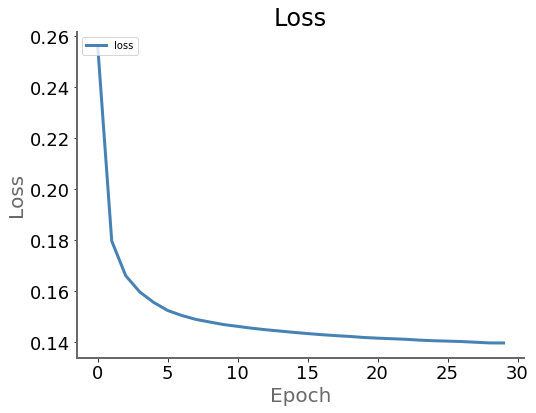

In [13]:
pwk.plot_history(history,  plot={"Loss":['loss']}, save_as='03-history')

## Step 7 - Learning progression

<br>**Real images :**

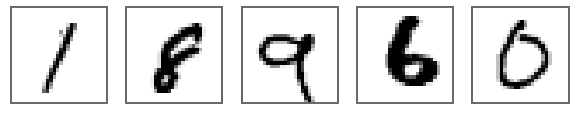

<br>**Noisy images :**

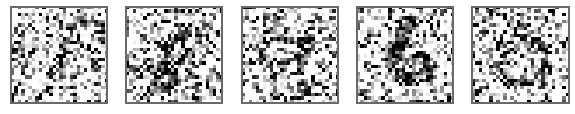

<br>**Learning...**

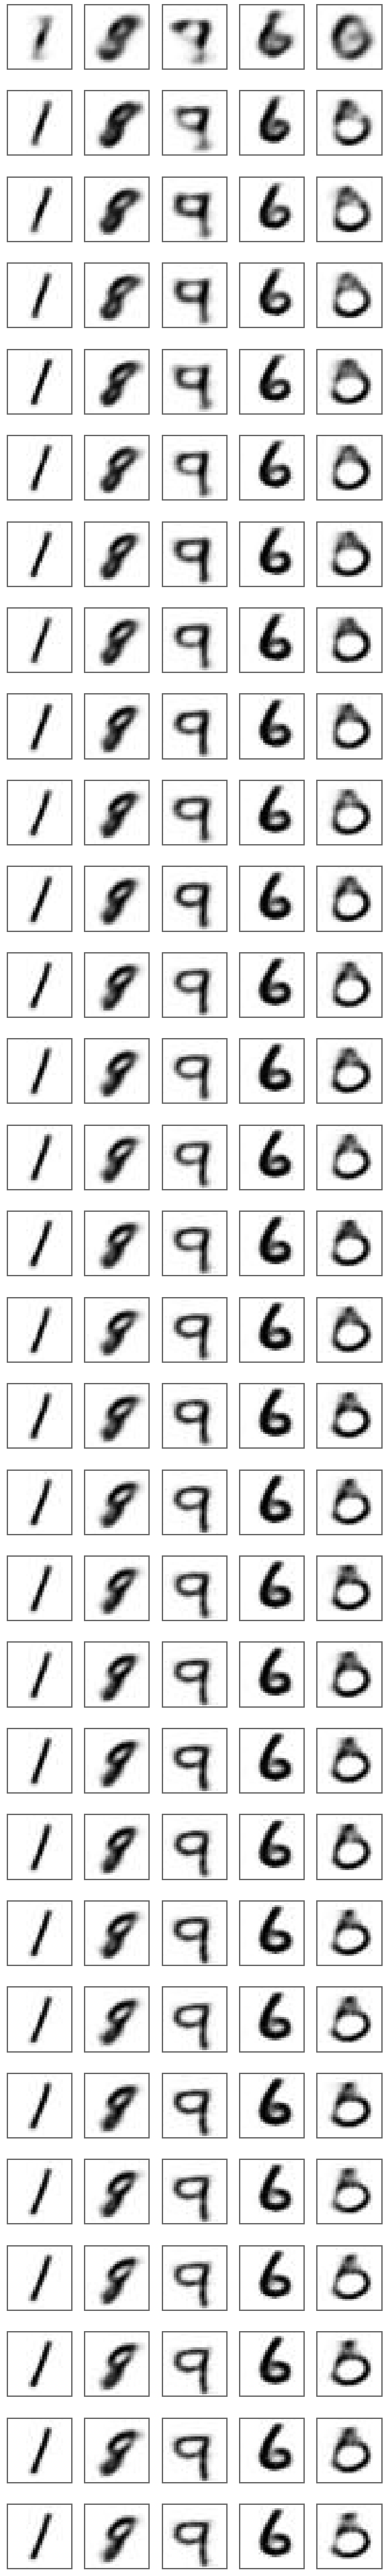

<br>**Noisy images :**

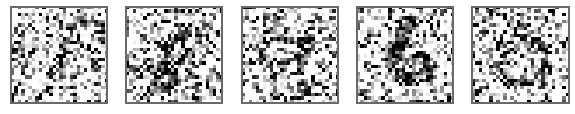

<br>**Real images :**

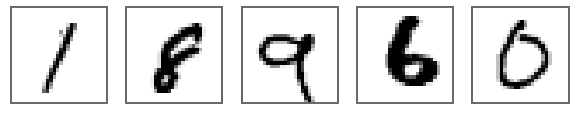

In [14]:
imgs=[]
labels=[]
for epoch in range(epochs):
    for i in range(5):
        filename = './run/images/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)
        

pwk.subtitle('Real images :')
pwk.plot_images(y_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='04-original-real')

pwk.subtitle('Noisy images :')
pwk.plot_images(x_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='05-original-noisy')

pwk.subtitle('Learning...')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='06-learning')

pwk.subtitle('Noisy images :')
pwk.plot_images(x_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as=None)

pwk.subtitle('Real images :')
pwk.plot_images(y_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as=None)


In [15]:
pwk.end()

End time is : Wednesday 27 January 2021, 19:25:03
Duration is : 00:02:14 426ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>